In [1]:
import numpy as np
import torch
import gif
import matplotlib.pyplot as plt
import pytorch_lightning as pl 
from pathlib import Path
import yaml
import matplotlib.ticker as tickerd
import matplotlib.colors as colors

from matplotlib.tri import Triangulation as triang

In [2]:
from core.autoencoder import AutoEncoder
from core.structured_data import GridDataModule

In [4]:
#### Change the entries here to analyze a new model / dataset
experiment_name = 'ignition_maxskip_qcnn'
model_checkpoint_path = Path('C:\\Users\\Kevin\\Google Drive\\Research\\QuadConv\\lightning_logs\\ignition_maxskip_qcnn\\lassen_version_2') / 'checkpoints'
input_shape = (1,1,2500)
###################

checkpoint = list(model_checkpoint_path.glob('epoch=*.ckpt'))

print(model_checkpoint_path)

print(f'Loading experiment {experiment_name} and {checkpoint[0]} ')

experiment_path = Path('../experiments/')
model_yml = list(experiment_path.rglob(experiment_name + '*'))

with model_yml[0].open() as file:
    config = yaml.safe_load(file)

config['data']['data_dir'] = 'C:\\Users\\Kevin\\Google Drive\\Research\\QuadConv\\data\\ignition_center_cut'

data_module = GridDataModule(**config['data'])
data_module.setup(stage='analyze')
dataset = data_module.analyze_data()

#TODO Make a dataloader option that outputs 1 experiments worth of data

model = AutoEncoder.load_from_checkpoint(checkpoint[0], input_shape=input_shape, **config['model'])
model.eval()
model.to('cpu')

C:\Users\Kevin\Google Drive\Research\QuadConv\lightning_logs\ignition_maxskip_qcnn\lassen_version_2\checkpoints
Loading experiment ignition_maxskip_qcnn and C:\Users\Kevin\Google Drive\Research\QuadConv\lightning_logs\ignition_maxskip_qcnn\lassen_version_2\checkpoints\epoch=44432.ckpt 


AutoEncoder(
  (loss_fn): SobolevLoss()
  (output_activation): Tanh()
  (encoder): Encoder(
    (activation1): CELU(alpha=1.0)
    (activation2): CELU(alpha=1.0)
    (cnn): Sequential(
      (0): QuadConvLayer(
        (G): Sequential(
          (0): Linear(in_features=2, out_features=16, bias=False)
          (1): Sin()
          (2): Linear(in_features=16, out_features=16, bias=False)
          (3): Sin()
          (4): Linear(in_features=16, out_features=16, bias=False)
          (5): Sin()
          (6): Linear(in_features=16, out_features=16, bias=False)
          (7): Unflatten(dim=1, unflattened_size=(1, 16))
        )
      )
      (1): PoolQuadConvBlock(
        (resample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (conv1): QuadConvLayer(
          (G): Sequential(
            (0): Linear(in_features=2, out_features=16, bias=False)
            (1): Sin()
            (2): Linear(in_features=16, out_features=16, bias=False)
            (3

In [5]:
save_path = model_checkpoint_path / '..' 

processed_data = model(dataset).detach().numpy()

difference_norm = torch.sqrt((dataset - processed_data)**2)

relative_difference_norm = difference_norm / torch.sqrt((dataset)**2)

In [ ]:
# GRID!


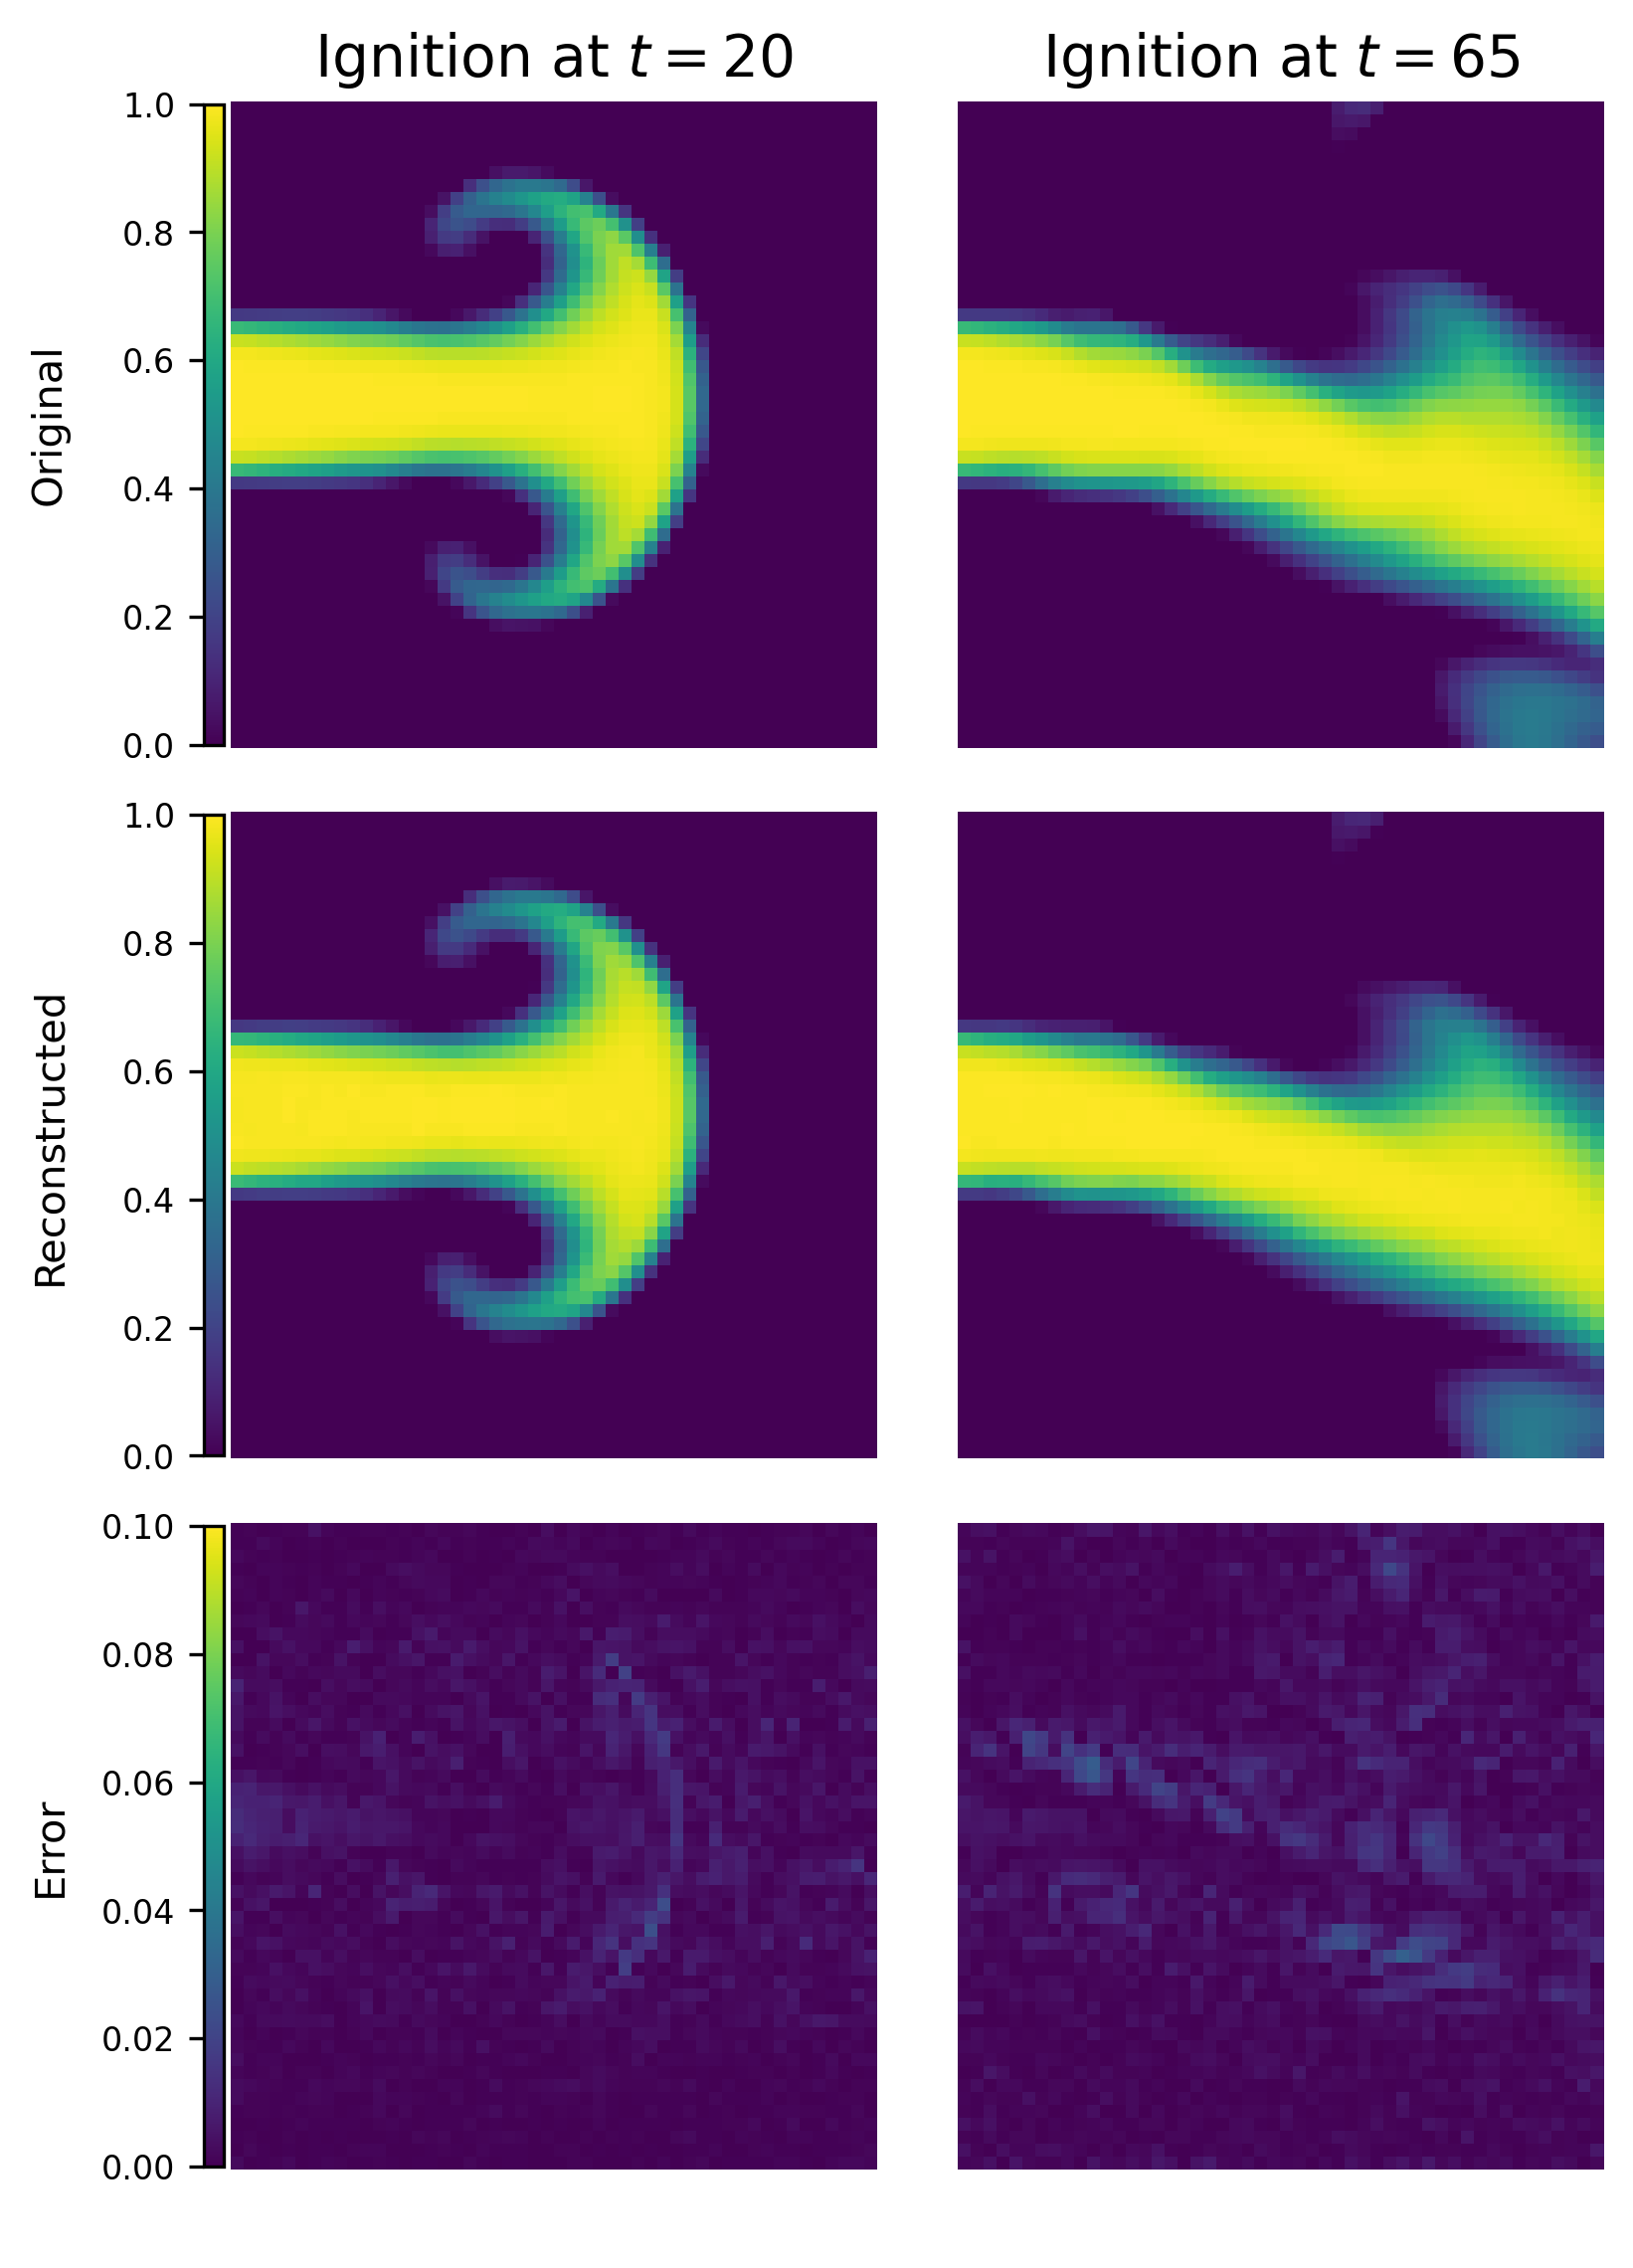

In [29]:
time_steps = [20 , 65]

max_disp = torch.max(dataset)
min_disp = torch.min(dataset)

max_disp = 1
min_disp = 0

x = np.linspace(0,1,50)
y = np.linspace(0,1,50)

grid = np.meshgrid(*(x,y))


fig = plt.figure(figsize=(6,9), dpi=300)

axs = [fig.add_subplot(3,2,i+1) for i in range(6)]


map_it0 = axs[0].pcolor(*grid,dataset[time_steps[0],0,:].reshape(50,50),  vmin=min_disp, vmax=max_disp)

map_it2 = axs[2].pcolor(*grid,processed_data[time_steps[0],0,:].reshape(50,50), vmin=min_disp, vmax=max_disp)

map_it4 = axs[4].pcolor(*grid, difference_norm[time_steps[0],0,:].reshape(50,50),  vmin=0, vmax=0.1)

axs[1].pcolor(*grid, dataset[time_steps[1],0,:].reshape(50,50),  vmin=min_disp, vmax=max_disp)

axs[3].pcolor(*grid, processed_data[time_steps[1],0,:].reshape(50,50), vmin=min_disp, vmax=max_disp)

axs[5].pcolor(*grid, difference_norm[time_steps[1],0,:].reshape(50,50), vmin=0, vmax=0.1)

# Tweak all the axes 
for ax in axs:
    #ax.label_outer()
    ax.set_aspect('equal')
    #ax.margins(x=0.01, y = 0.06)
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    #ax.set_axis_off()   

plt.subplots_adjust(hspace = 0.1, wspace = 0.1)

axs[1].set_axis_off()   
axs[3].set_axis_off()   
axs[5].set_axis_off()   

# Make colorbars 
bbox = axs[0].get_position()
pos = bbox.bounds
ax_cb = fig.add_axes([pos[0] - 0.015, pos[1] + 0.001 , pos[2]*0.03, pos[3] - 0.002])
plt.colorbar(map_it0, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.tick_params(labelsize = 8)

bbox = axs[2].get_position()
pos = bbox.bounds
ax_cb = fig.add_axes([pos[0]- 0.015, pos[1] + 0.001, pos[2]*0.03, pos[3] - 0.002])
plt.colorbar(map_it2, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.tick_params(labelsize = 8)

bbox = axs[4].get_position()
pos = bbox.bounds
ax_cb = fig.add_axes([pos[0] - 0.015, pos[1] + 0.001, pos[2]*0.03, pos[3] - 0.002])
plt.colorbar(map_it4, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.tick_params(labelsize = 8)



axs[0].set_title(r'Ignition at $t=20$', fontsize=14)

axs[1].set_title(r'Ignition at $t=65$', fontsize=14)


axs[0].yaxis.set_label_coords(-0.25,0.5)
axs[0].set_ylabel('Original', fontsize = 10)
axs[2].yaxis.set_label_coords(-0.25,0.5)
axs[2].set_ylabel('Reconstructed', fontsize = 10)
axs[4].yaxis.set_label_coords(-0.25,0.5)
axs[4].set_ylabel('Error', fontsize = 10)


fig.savefig(save_path / 'ignition_grid_viz_results.pdf', format='pdf')


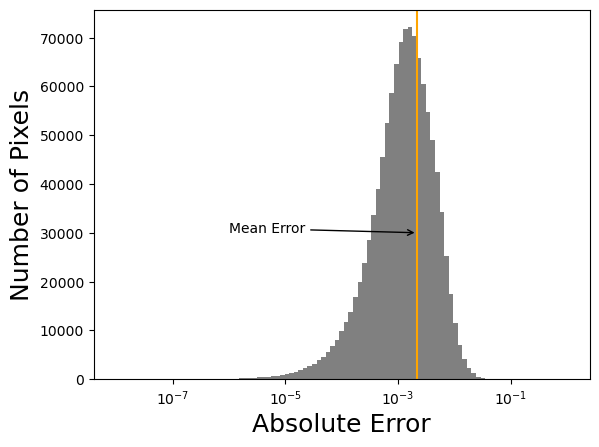

In [31]:

plt.hist(difference_norm.flatten(),bins=np.logspace(np.log10(1e-8),np.log10(1.0), 100), log=False, color='grey')
plt.gca().set_xscale("log")
plt.ylabel('Number of Pixels', fontsize=18)
plt.xlabel('Absolute Error', fontsize=18)

plt.axvline(x = torch.mean(difference_norm), color = 'orange', label = 'Mean Error')
plt.annotate('Mean Error' , (torch.mean(difference_norm),3e4), xytext=(1e-6, 3e4), textcoords='data', arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))

plt.savefig(save_path / 'ignition_grid_abs_error_histogram.pdf', format='pdf')


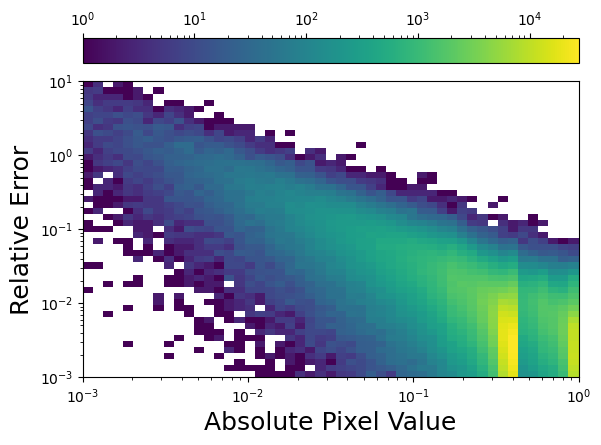

In [30]:
xbin = np.logspace(np.log10(1e-3),np.log10(1.), 50)
ybin = np.logspace(np.log10(1e-3),np.log10(10), 50)

plt.hist2d( torch.abs(dataset.flatten()).numpy(), relative_difference_norm.flatten().numpy(), bins=[xbin,ybin], norm = colors.LogNorm())

plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.colorbar(location='top')
plt.xlabel('Absolute Pixel Value', fontsize=18)
plt.ylabel('Relative Error', fontsize=18)

plt.savefig(save_path / 'ignition_grid_abs_rel_histogram.pdf', format='pdf')